# Integrate three tonsil sections in the RNA modality

In this notebook, we used SpaMosaic to integrate three tonsillar sections in the RNA modality. All three sections were measured by 
10x Genomics Visium RNA and protein co-profiling technology. The first and second sections are two sequential sections, and transcriptome 
and protein (ADT) profiles were acquired for all three sections. We retained the transcriptome profiles of the three sections for horizontal settings.

Data used in this notebook can be downloaded from [google drive](https://drive.google.com/drive/folders/1O8HKz3Caf8DfMSFhjfta_qXt6LyjlfTm?usp=drive_link).

In [1]:
import os
import scanpy as sc
from os.path import join

import sys
# sys.path.insert(0, '../..')

from spamosaic.framework import SpaMosaic

To use the mclust clustering algorithm, we manually set the `R` and `rpy2` path here.

In [2]:
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # for CuBLAS operation and you have CUDA >= 10.2
import spamosaic.utils as utls
from spamosaic.preprocessing import RNA_preprocess, ADT_preprocess, Epigenome_preprocess

In [3]:
ad1_rna = sc.read_h5ad('./s1_adata_rna.h5ad')
ad2_rna = sc.read_h5ad('./s2_adata_rna.h5ad')
ad3_rna = sc.read_h5ad('./s3_adata_rna.h5ad')

### preprocessing

SpaMosaic expects <b>batch-corrected low-dimensional representations </b> for each modality as input. Therefore, for the raw count assays of each modality, SpaMosaic performs feature selection and dimension reduction to obtain the low-dimensional representations. Then, Harmony is performed to integrate these representations in each modality (<b>optional</b>, depending on the presence of strong batch effects). 

By default, the feature selection and dimension reduction consist of following steps:

- RNA assays: highly variable gene selection $\rightarrow$ log normalization $\rightarrow$ PCA 

- epigenome assays: highly variable peak selection $\rightarrow$ TF-IDF transformation $\rightarrow$ log normalization $\rightarrow$ PCA 

- protein assays: centered log ratio normalization $\rightarrow$ PCA

In horizontal integration, SpaMosaic requires the input in the format of
``` Python
{
    'modality_name': [adata1, adata2, adata3, ...]
}
```

In the dictionary, each key represents a modality and each modality key corresponds to list of `anndata` objects. Each `anndata` object contains modality-specific information for a particular section.

In [4]:
input_dict = {
    'rna': [ad1_rna, ad2_rna, ad3_rna],
}

input_key = 'dimred_bc'

Parameters in the following `RNA_preprocess` function:
* `batch_corr`: whether to perform batch correction with Harmony
* `favor`: following the standard 'scanpy' preprocessing workflow or an 'adapted' workflow
* `n_hvg`:      how many highly variable genes to select
* `batch_key`:  the key in the row metadata that holds the batch labels
* `key`:        the key in `.obsm` that will hold the output low-dimensional representations

After preprocessing, the low-dimensional representations can be accessed by: `ad1_rna.obsm[input_key]`, `ad2_rna.obsm[input_key]`, ...

In [5]:
RNA_preprocess(input_dict['rna'], batch_corr=True, favor='scanpy', n_hvg=5000, batch_key='src', key=input_key)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


### training

SpaMosaic employs modality-specific graph neural networks to embed each modality's input into latent space. In horizontal integration, all sections have only one modality, thus each section has only one set of embeddings. 

The crucial parameters include:
- `intra_knn`: how many nearest neighbors to consider when searching for spatial neighbors within the same section
- `inter_knn`: how many nearest neighbors to consider when searching for mutual nearest neighbors between sections
- `w_g`: the weight for spatial-adjacency graph, `1-w_g` is the weight for expression-adjacency graph

for training:
- `net`: which graph neural network to use (only support wlgcn now)
- `lr`: learning rate
- `n_epochs`: number of training epochs
- `w_rec_g`: the loss weight for reconstructing original graph structure. If the target dataset contains protein modality, we recommend a low value for w_rec_g (e.g., 0); if it contains epigenome modality, we recommend a high value for w_rec_g (e.g., 1).

In [6]:
model = SpaMosaic(
    modBatch_dict=input_dict, input_key=input_key,
    batch_key='src', intra_knn=2, inter_knn=2, w_g=0.8,
    seed=1234, 
    device='cuda:0'
)

model.train(net='wlgcn', lr=0.01, n_epochs=100, w_rec_g=0.)

batch0: ['rna']
batch1: ['rna']
batch2: ['rna']
------Calculating spatial graph...
The graph contains 8652 edges, 4326 cells.
2.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 9038 edges, 4519 cells.
2.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 9042 edges, 4521 cells.
2.0000 neighbors per cell on average.
Number of mnn pairs for rna:28890


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 82.82it/s]


### inference

After training, SpaMosaic can infer the modality-specific embedding for each section. These embeddings will be directly saved in original `anndata` objects. For example, the RNA-specific embeddings can be accessed by `ad1_rna.obsm['emb']`, `ad2_rna.obsm['emb']`, .... 

The following `infer_emb` function will return a <b>new</b> list of `anndata` objects, which save the final/merged embeddings for spatial clustering. The final embeddings can be accessed by `ad_embs[0].obsm['merged_emb']`, `ad_embs[1].obsm['merged_emb']`, ...

Since we have only modality in horizontal integration,  the final/merged embeddings are exactly the same as the RNA-specific embeddings.

In [7]:
ad_embs = model.infer_emb(input_dict, emb_key='emb', final_latent_key='merged_emb')
ad_mosaic = sc.concat(ad_embs)
ad_mosaic = utls.get_umap(ad_mosaic, use_reps=['merged_emb'])

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualize the final embeddings using UMAP plots, spot are colored by batch labels

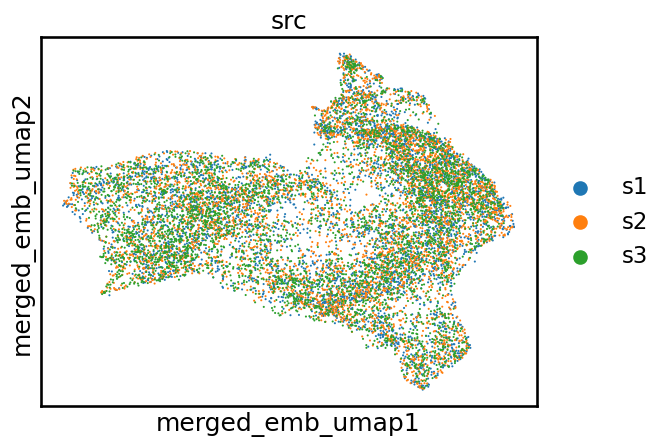

In [8]:
utls.plot_basis(ad_mosaic, basis='merged_emb_umap', color=['src'])

### clustering

Parameters for the following `utls.clustering` function:
- `n_cluster`: expected number of clusters
- `used_obsm`: the target key in the `ad_mosaic.obsm` that holds the embeddings for clustering input
- `algo`: which clustering algorithm to use, `mclust` or `kmeans`. Sometimes `mclust` can fail to output clustering, it will automatically output the `kmeans` outputs.
- `key`: the key in the row metadata that will hold the output clustering labels.

Generally, SpaMosaic works better with the mclust algorithm in spatial domain identification task. The final/merged embeddings are used as input for mclust and the clustering labels can be accessed by `ad_mosaic.obs['mclust']`.

In [9]:
utls.clustering(ad_mosaic, n_cluster=7, used_obsm='merged_emb', algo='mclust', key='mclust')
utls.split_adata_ob(ad_embs, ad_mosaic, 'obs', 'mclust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


Spatial plots of clustering label for individual sections

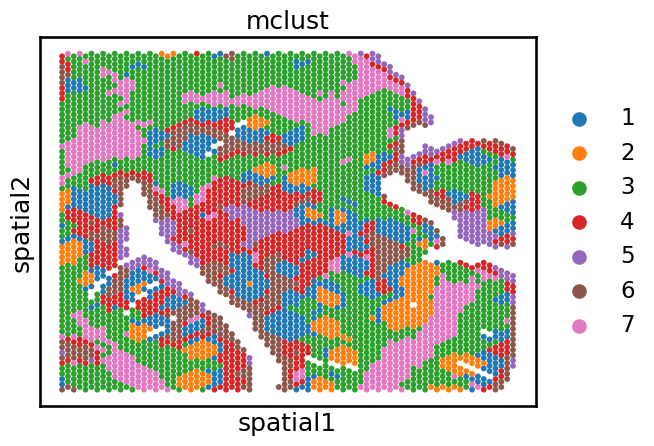

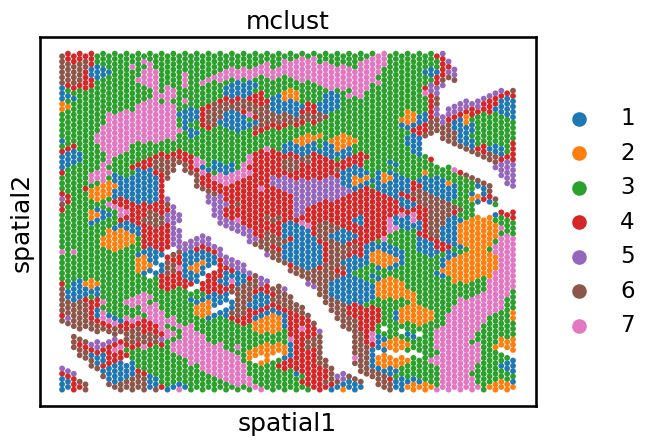

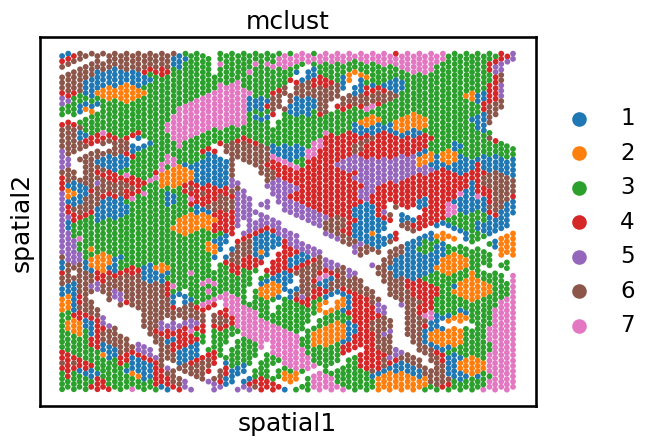

In [10]:
for ad in ad_embs:
    utls.plot_basis(ad, 'spatial', 'mclust', s=70)